<!-- PROJECT LOGO -->
<br />
<div align="center">
  <a>
    <img src="https://res.cloudinary.com/dek4evg4t/image/upload/v1729273000/Group_4.png" alt="Logo" width="30%">
  </a>
</div>

### 🖹 Descripción:
Este Proyecto tiene como objetivo aplicar redes neuronales convolucionales (CNN) para realizar una clasificación multiclase de imágenes mediante aprendizaje supervisado. Utilizando el [Covid-19 Image Dataset de Kaggle](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset), que contiene imágenes de rayos X clasificadas en tres categorías (Covid-19, Normal, Neumonía), en este proyecto se desarrollarán clasificadores capaces de diagnosticar enfermedades pulmonares. El proyecto también explora el uso de PyTorch para el desarrollo de modelos de Machine Learning y herramientas de monitoreo, como Weights and Biases, para el seguimiento en tiempo real del proceso de entrenamiento.

### ✍️ Autores:
* Angelo Ortiz Vega - [@angelortizv](https://github.com/angelortizv)
* Alejandro Campos Abarca - [@MajinLoop](https://github.com/MajinLoop)

### 📅 Fecha:
20 de octubre de 2024

### 📝 Notas:
Este es el segundo proyecto del curso IC6200 - Inteligencia Artificial. En este notebook, titulado "Covid-19 Classification", se profundiza en técnicas de data augmentation, preprocesamiento de imágenes con filtros, y fine-tuning de modelos CNN como VGG16 para mejorar la capacidad de generalización de las redes neuronales convolucionales.

### Otras notas:
Asegurarse de contar con Python y las siguientes bibliotecas instaladas: torch, torchvision, cv2, numpy, matplotlib, Pillow.

# 1. Configuración

## 1.1 Importación de librerías

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader, ConcatDataset
from torchvision import datasets, models
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary

from torchviz import make_dot
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import wandb
import cv2 
from PIL import Image
import utils as u

## 1.2 Verificación de CUDA

In [2]:
u.check_cuda_info()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA available: True
CUDA version: 11.8
Number of GPUs: 1
Current GPU: 0


## 1.3 Definición de Constantes

In [3]:
SEED_VALUE = 153
IMAGE_RESIZE = 128
IMAGE_NORMALIZE = 0.5

HYPERPARAMETERS = \
{
    "learning_rate": 0.001,
    "epochs": 20,
    "batch_size": 32,
    "dropout_rate": 0.5,
}

# Paths
TRAIN_DATA_PATH = 'data/Covid19-dataset/train'
TEST_DATA_PATH = 'data/Covid19-dataset/test'

VISUALIZATION_DIR = 'visualization'
MODEL_B_GRAPHS_DIR = 'Model_B_graphs'
MODEL_A_GRAPHS_DIR = 'Model_A_graphs'

CHECKPOINTS_DIR = 'checkpoints'
MODEL_B_CHECKPOINTS_DIR = 'Model_B'
MODEL_A_CHECKPOINTS_DIR = 'Model_A'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Seleccionar dispositivo (GPU si disponible, si no CPU)

## 1.4 Configuración de librerías

In [4]:
# PyTorch settings
torch.manual_seed(SEED_VALUE)

# Configuración de Weights & Biases
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alejandro-campos (alejandro-campos-technological-institute-of-costa-rica). Use `wandb login --relogin` to force relogin


True

# 2. Preprocesamiento y data augmentation

## 2.1 Definición de filtros

In [5]:
def bilateral_filter(img):
    np_img = np.array(img)
    filtered_img = cv2.bilateralFilter(np_img, d=15, sigmaColor=75, sigmaSpace=75)
    return Image.fromarray(filtered_img) 

def canny_edge_filter(img, min_val=40, max_val=85):
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # PIL (RGB) -> OpenCV (BGR)
    img = cv2.Canny(img, min_val, max_val)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV (BGR) -> PIL (RGB)
    return Image.fromarray(img)

## 2.2 Definición de transforms

In [6]:
transform_r = transforms.Compose(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Grayscale(num_output_channels=3),  # Cambiado a 3 canales
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

transform_r_augmented = transforms.Compose(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),
        transforms.Grayscale(num_output_channels=3),  # Cambiado a 3 canales
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

transform_b = transforms.Compose(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Lambda(lambda img: bilateral_filter(img)),
        transforms.Grayscale(num_output_channels=3),  # Cambiado a 3 canales
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

transform_b_augmented = transforms.Compose(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),
        transforms.Lambda(lambda img: bilateral_filter(img)),
        transforms.Grayscale(num_output_channels=3),  # Cambiado a 3 canales
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

transform_c = transforms.Compose(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Lambda(lambda img: canny_edge_filter(img)),
        transforms.Grayscale(num_output_channels=3),  # Cambiado a 3 canales
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

transform_c_augmented = transforms.Compose(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),
        transforms.Lambda(lambda img: canny_edge_filter(img)),
        transforms.Grayscale(num_output_channels=3),  # Cambiado a 3 canales
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

#  3. Carga de datos

## 3.1 Dataloaders

In [7]:
def get_sub_data_loader(dataset, fraction_of_data=0.1):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    subset_size = int(np.floor(fraction_of_data * dataset_size))
    np.random.shuffle(indices)
    subset_indices = indices[:subset_size]
    sub_dataset = Subset(dataset, subset_indices)
    # print(f'Subset size: {len(sub_dataset)}')
    return DataLoader(dataset=sub_dataset, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
#-----------------------------------------------------------------------------------------------------------------------------


# Train data
# Raw
train_dataset_r = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_r)
train_dataset_r_augmented = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_r_augmented)
combined_train_dataset_r = ConcatDataset([train_dataset_r, train_dataset_r_augmented])
train_loader_r = DataLoader(dataset=combined_train_dataset_r, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
train_sub_loader_r = get_sub_data_loader(dataset=combined_train_dataset_r)

# Bilateral
train_dataset_b = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_b_augmented)
train_dataset_b_augmented = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_b_augmented)
combined_train_dataset_b = ConcatDataset([train_dataset_b, train_dataset_b_augmented])
train_loader_b = DataLoader(dataset=combined_train_dataset_b, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
train_sub_loader_b = get_sub_data_loader(dataset=combined_train_dataset_b)

# Canny
train_dataset_c = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_c_augmented)
train_dataset_c_augmented = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_c_augmented)
combined_train_dataset_c = ConcatDataset([train_dataset_c, train_dataset_c_augmented])
train_loader_c = DataLoader(dataset=combined_train_dataset_c, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
train_sub_loader_c = get_sub_data_loader(dataset=combined_train_dataset_c)
#-----------------------------------------------------------------------------------------------------------------------------

# Test data
# Raw
test_dataset_r = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_r_augmented)
test_loader_r = DataLoader(dataset=test_dataset_r, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
# Bilateral
test_dataset_b = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_b_augmented)
test_loader_b = DataLoader(dataset=test_dataset_b, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
# Canny
test_dataset_c = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_c_augmented)
test_loader_c = DataLoader(dataset=test_dataset_c, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
#-----------------------------------------------------------------------------------------------------------------------------


print(f'Tamaño del conjunto de entrenamiento: {len(train_loader_r.dataset)}')
print(f'Tamaño del conjunto de testing: {len(test_loader_r.dataset)}')

Tamaño del conjunto de entrenamiento: 502
Tamaño del conjunto de testing: 66


# 4. Modelo A - ResNet50

Razones de elección Resnet

- **Arquitectura Profunda**: ResNet50 tiene 50 capas, lo que le permite aprender representaciones de alto nivel y características complejas sin sufrir el problema del desvanecimiento del gradiente.
- **Conexiones Residuales**: Estas conexiones permiten que la red aprenda funciones de identidad, facilitando el entrenamiento de redes más profundas. Las conexiones residuales permiten que la información fluya más fácilmente a través de la red, lo que mejora la estabilidad del entrenamiento.
- **Rendimiento Sólido**: Ha demostrado ser altamente efectiva en competiciones de clasificación de imágenes, como ImageNet, donde ha logrado clasificaciones superiores.
- **Transfer Learning**: Utiliza pesos preentrenados de ImageNet, lo que ahorra tiempo y recursos, además de proporcionar un buen punto de partida para la clasificación en tareas específicas con conjuntos de datos más pequeños.
- **Flexibilidad**: Se puede personalizar fácilmente para diferentes tareas de clasificación ajustando la capa final sin necesidad de rediseñar toda la red.

## 4.1 Definición

In [8]:
weights = ResNet50_Weights.IMAGENET1K_V1  # Cargar los pesos preentrenados

# Modelo A Raw
model_a_r = models.resnet50(weights=weights)
num_ftrs = model_a_r.fc.in_features
model_a_r.fc = nn.Linear(num_ftrs, 3)  # 3 clases: Covid-19, Normal, Viral Pneumonia
model_a_r = model_a_r.to(DEVICE)

# Modelo A Bilateral
model_a_b = models.resnet50(weights=weights)
num_ftrs = model_a_b.fc.in_features
model_a_b.fc = nn.Linear(num_ftrs, 3)  # 3 clases: Covid-19, Normal, Viral Pneumonia
model_a_b = model_a_b.to(DEVICE)

# Modelo A Canny
model_a_c = models.resnet50(weights=weights)
num_ftrs = model_a_c.fc.in_features
model_a_c.fc = nn.Linear(num_ftrs, 3)  # 3 clases: Covid-19, Normal, Viral Pneumonia
model_a_c = model_a_c.to(DEVICE)

El código comienza cargando los pesos preentrenados de **ResNet50** desde el conjunto de datos **ImageNet** utilizando `ResNet50_Weights.IMAGENET1K_V1`, lo que permite que el modelo aproveche el conocimiento adquirido previamente para reconocer características visuales. Luego, se inicializa el modelo ResNet50 con estos pesos mediante `models.resnet50(weights=weights)`. A continuación, se obtiene el número de características de la capa de salida del modelo original a través de `num_ftrs = model_a.fc.in_features`, y se reemplaza la capa final por una nueva capa lineal (`nn.Linear`) que está configurada para clasificar tres clases específicas: **Covid-19**, **Normal** y **Viral Pneumonia**. 

In [9]:
summary(model_a_r, (3, IMAGE_RESIZE, IMAGE_RESIZE))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─ReLU: 1-3                              [-1, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [-1, 64, 32, 32]          --
├─Sequential: 1-5                        [-1, 256, 32, 32]         --
|    └─Bottleneck: 2-1                   [-1, 256, 32, 32]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 32, 32]         16,38

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 64, 64]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 64, 64]          128
├─ReLU: 1-3                              [-1, 64, 64, 64]          --
├─MaxPool2d: 1-4                         [-1, 64, 32, 32]          --
├─Sequential: 1-5                        [-1, 256, 32, 32]         --
|    └─Bottleneck: 2-1                   [-1, 256, 32, 32]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          4,096
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-3                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 32, 32]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 32, 32]          128
|    |    └─ReLU: 3-6                    [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 32, 32]         16,38

## 4.2 Visualización

In [10]:
x = torch.randn(1, 3, 128, 128).to(device=DEVICE)  # Tensor de ejemplo
y = model_a_r(x)

dot = make_dot(y, params=dict(list(model_a_r.named_parameters())))
dot.attr(dpi='300')
file_name = 'model_a_graph'
directory = os.path.join(VISUALIZATION_DIR, MODEL_A_GRAPHS_DIR)
dot.render(filename=file_name, directory=directory, format="png") 
dot.view()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.721041 to fit


'visualization\\Model_A_graphs\\model_a_graph.pdf'

##  4.3 Funcion de entrenamiento y registro en W&B

In [11]:
def train(model, train_data_loader, model_name):
    criterion = nn.CrossEntropyLoss()
    initial_wandb_learning_rate = wandb.config.learning_rate # Guardar el learning rate inicial
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    for epoch in range(wandb.config.epochs):
        model.train()  # Modo de entrenamiento

        accumulated_epoch_loss = 0
        epoch_correct_predictions = 0
        epoch_total_samples = 0

        # Iteramos sobre los datos
        for images, labels in train_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Limpiar gradientes: Se restablecen los gradientes acumulados en el optimizador a cero para evitar que se sumen a los gradientes del lote actual.
            optimizer.zero_grad()

            # Forward: Se pasan las imágenes a través del modelo para obtener las predicciones (model_predictions).
            model_predictions = model(images)

            # Cálculo de la pérdida: Se calcula la pérdida utilizando la función de pérdida definida anteriormente,
            # comparando las predicciones (model_predictions) con las etiquetas verdaderas (labels).
            batch_loss = criterion(model_predictions, labels)

            # Sumar la pérdida de este lote a la pérdida total de la época
            accumulated_epoch_loss += batch_loss.item()

            _, predicted = torch.max(model_predictions, 1)  # Obtener las predicciones con el mayor valor (clase más probable)
            batch_correct_predictions = (predicted == labels).sum().item()    # Contar cuántas predicciones son correctas
            total_samples = labels.size(0)                          # Total de elementos en el batch

            epoch_correct_predictions += batch_correct_predictions
            epoch_total_samples += total_samples

            # Backward pass: Se realiza la propagación hacia atrás para calcular los gradientes de la pérdida con respecto a los parámetros del modelo.
            batch_loss.backward()

            # Actualizar parámetros: Se actualizan los parámetros del modelo utilizando los gradientes calculados en la etapa anterior.
            optimizer.step()

        # Cálculo de la accuracy promedio de la época
        epoch_loss = accumulated_epoch_loss / len(train_data_loader)
        epoch_accuracy = 100 * epoch_correct_predictions / epoch_total_samples

        # Imprimir pérdida promedio y accuracy por época, así como el LR
        current_lr = optimizer.param_groups[0]['lr']    # Obtener el learning rate actual
        print(f'Epoch [{epoch + 1}/{wandb.config.epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Learning Rate: {current_lr:.6f}')

        # WandB
        wandb.config.update({"learning_rate": current_lr})
        wandb.log({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_accuracy, "model": model_name}, commit=True)

        scheduler.step(epoch_loss)
    
    # Restaurar el valor inicial de learning rate después del entrenamiento
    wandb.config.update({"learning_rate": initial_wandb_learning_rate})

## 4.4 Funcion de evaluación

In [12]:
def make_wandb_project(
        project_name: str,
        model_name: str,
        hyperparameters: dict,
        model,
        print_msg: str,
        data_loader: DataLoader,
        wandb_watch_log = "all"):
    
    wandb.init(project=project_name, name=model_name)
    wandb.config.update(hyperparameters)
    wandb.watch(model, log=wandb_watch_log)
    print(print_msg)
    train(model=model, train_data_loader=data_loader, model_name=model)
    print()
    wandb.unwatch(model)
    wandb.finish()

def evaluate_model(model, test_data_loader):
    correct = 0
    total = 0

    with torch.no_grad():

        for images, labels in test_data_loader:
            
            # Mueve las imágenes y las etiquetas al dispositivo correspondiente
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            model_predictions = model(images)
            _, predicted = torch.max(model_predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')


def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:

            # Mueve las imágenes y las etiquetas al dispositivo correspondiente
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)


def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.show()

##  4.5 Entrenamiento con los diferentes datasets

In [13]:
make_wandb_project(project_name="project_a_r", model_name="model_a_r", hyperparameters=HYPERPARAMETERS,
                   model=model_a_r, print_msg="Training model A Raw", data_loader=train_loader_r)

make_wandb_project(project_name="project_a_b", model_name="model_a_b", hyperparameters=HYPERPARAMETERS,
                   model=model_a_b, print_msg="Training model A Bilateral", data_loader=train_loader_b)

make_wandb_project(project_name="project_a_c", model_name="model_a_c", hyperparameters=HYPERPARAMETERS,
                   model=model_a_c, print_msg="Training model A Canny", data_loader=train_loader_c)

Training model A Raw


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 0.7081, Accuracy: 75.30%, Learning Rate: 0.001000
Epoch [2/20], Loss: 0.2676, Accuracy: 89.64%, Learning Rate: 0.001000
Epoch [3/20], Loss: 0.1837, Accuracy: 92.83%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.1394, Accuracy: 95.22%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.1700, Accuracy: 93.43%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.1865, Accuracy: 93.63%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.2293, Accuracy: 93.63%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.2152, Accuracy: 93.43%, Learning Rate: 0.000500
Epoch [9/20], Loss: 0.1459, Accuracy: 96.22%, Learning Rate: 0.000500
Epoch [10/20], Loss: 0.0653, Accuracy: 97.21%, Learning Rate: 0.000500
Epoch [11/20], Loss: 0.0760, Accuracy: 97.81%, Learning Rate: 0.000500
Epoch [12/20], Loss: 0.0509, Accuracy: 97.61%, Learning Rate: 0.000500
Epoch [13/20], Loss: 0.1041, Accuracy: 96.81%, Learning Rate: 0.000500
Epoch [14/20], Loss: 0.0613, Accuracy: 97.81%, Learning Rate: 0.000500
Epoch [15/20], 

accuracy,▁▅▆▇▆▆▆▆▇▇██▇███████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▃▂▂▃▃▃▂▁▁▁▂▁▁▁▁▁▁▁
accuracy,97.60956
epoch,19
loss,0.04678
model,ResNet( (conv1): C...


Training model A Bilateral


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 0.7468, Accuracy: 72.11%, Learning Rate: 0.001000
Epoch [2/20], Loss: 0.3982, Accuracy: 86.85%, Learning Rate: 0.001000
Epoch [3/20], Loss: 0.3066, Accuracy: 89.04%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.3309, Accuracy: 88.25%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.1966, Accuracy: 93.23%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.1591, Accuracy: 94.62%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.1329, Accuracy: 95.22%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.1343, Accuracy: 95.42%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.1725, Accuracy: 94.42%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.1244, Accuracy: 96.02%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.1181, Accuracy: 94.22%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.1361, Accuracy: 95.82%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.1387, Accuracy: 94.82%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.0935, Accuracy: 96.81%, Learning Rate: 0.001000
Epoch [15/20], 

accuracy,▁▅▆▅▇▇▇▇▇▇▇▇▇█▇███▇▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▄▂▂▂▂▂▂▂▂▂▁▂▁▁▁▃▂
accuracy,94.62151
epoch,19
loss,0.13473
model,ResNet( (conv1): C...


Training model A Canny


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 0.9300, Accuracy: 62.15%, Learning Rate: 0.001000
Epoch [2/20], Loss: 0.5221, Accuracy: 78.09%, Learning Rate: 0.001000
Epoch [3/20], Loss: 0.4836, Accuracy: 82.67%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.4589, Accuracy: 80.48%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.4206, Accuracy: 82.87%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.4470, Accuracy: 83.07%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.4481, Accuracy: 83.07%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.3621, Accuracy: 85.86%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.3398, Accuracy: 85.26%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.3278, Accuracy: 86.06%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.2711, Accuracy: 88.84%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.2363, Accuracy: 90.84%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.2739, Accuracy: 89.64%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.2913, Accuracy: 89.04%, Learning Rate: 0.001000
Epoch [15/20], 

accuracy,▁▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▄▄▃▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁
accuracy,93.6255
epoch,19
loss,0.1673
model,ResNet( (conv1): C...


## 4.6 Evaluación de modelos A

In [14]:
print("Evaluating model A Raw")
evaluate_model(model=model_a_r, test_data_loader=test_loader_r)
print()

print("Evaluating model A Bilateral")
evaluate_model(model=model_a_b, test_data_loader=test_loader_b)
print()

print("Evaluating model A Canny")
evaluate_model(model=model_a_c, test_data_loader=test_loader_c)
print()

Evaluating model A Raw
Accuracy of the model on the test images: 95.45%

Evaluating model A Bilateral
Accuracy of the model on the test images: 90.91%

Evaluating model A Canny
Accuracy of the model on the test images: 84.85%



## 4.7 Matriz de confusión de los modelos A

Evaluando modelo A Raw


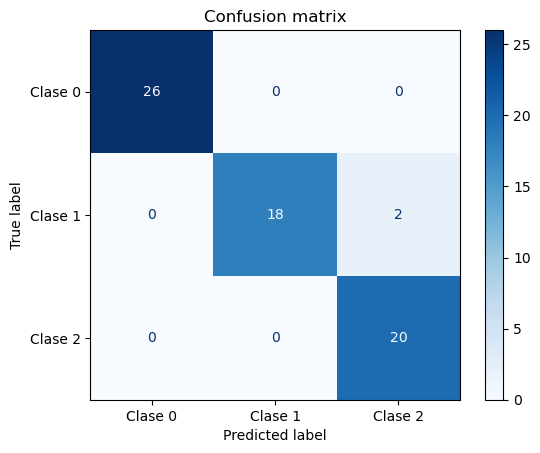

Evaluando modelo A Bilateral


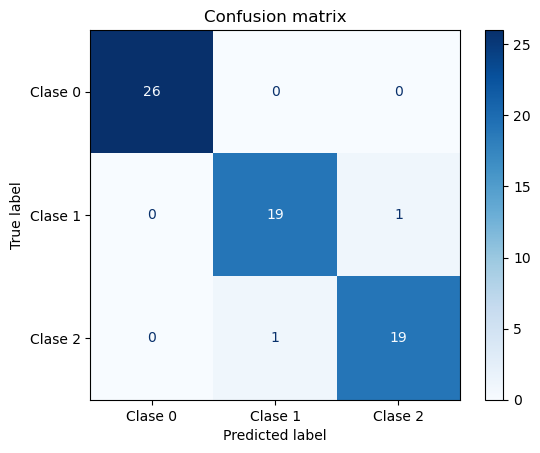

Evaluando modelo A Canny


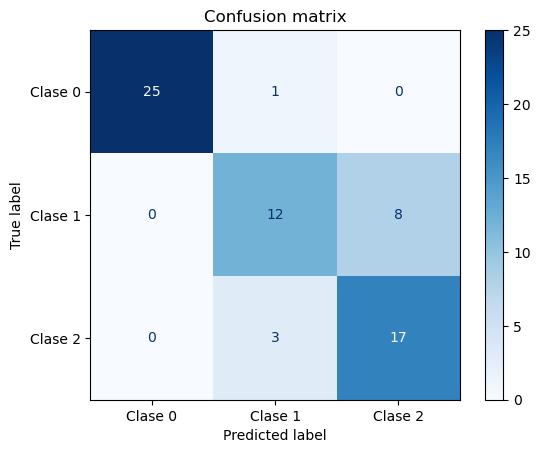

In [15]:
print("Evaluando modelo A Raw")
y_true_r, y_pred_r = get_predictions(model=model_a_r, data_loader=test_loader_r)
plot_confusion_matrix(y_true_r, y_pred_r, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo A Bilateral")
y_true_b, y_pred_b = get_predictions(model=model_a_b, data_loader=test_loader_b)
plot_confusion_matrix(y_true_b, y_pred_b, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo A Canny")
y_true_c, y_pred_c = get_predictions(model=model_a_c, data_loader=test_loader_c)
plot_confusion_matrix(y_true_c, y_pred_c, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

# 4.6 Exportar resultados

In [16]:
file_name = 'model_a_r.pth'
filepath = os.path.join(CHECKPOINTS_DIR, MODEL_A_CHECKPOINTS_DIR, file_name)

os.makedirs(os.path.dirname(filepath), exist_ok=True)

# Model A Raw
torch.save(model_a_r.state_dict(), filepath)

# Model A Bilateral
file_name = 'model_a_b.pth'
filepath = os.path.join(CHECKPOINTS_DIR, MODEL_A_CHECKPOINTS_DIR, file_name)
torch.save(model_a_b.state_dict(), filepath)

# Model A Canny
file_name = 'model_a_c.pth'
filepath = os.path.join(CHECKPOINTS_DIR, MODEL_A_CHECKPOINTS_DIR, file_name)
torch.save(model_a_c.state_dict(), filepath)